#Convolutional Neural Network
###Binary classification of real face and comics images
#####**Objective**: implementation of a deep-learning-based system discriminating between real faces and comics.
#####**Dataset**: Kaggle's "Comic faces" dataset, released under the CC-BY 4.0 license. A total of 20.000 images in 1024x1024 format.

#### *Import required libraries and dependences*

##### *Installing some dependences*

In [28]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### *Installing the libraries*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import random
import pickle
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import time
import sklearn
import seaborn as sn
import keras_tuner
from keras_tuner.tuners import RandomSearch, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

####*Loading and download the dataset*
##### (Use the Kaggle API credentials from the Kaggle API Token)
##### First, we set the directories as explained in the Kaggle API documentation. Then, the echo command is used as a source part of a pipeline. Here, it points to the correct directory for the kaggle.json file while calling the username and key.

In [8]:
# ATTENTION: 
#In case the next cell does not work, it probably means that the kaggle.json file is not in the correct directory.
#If this is the case, consider changing the directories:

#%cd ~/.kaggle
#!touch ~/.kaggle/kaggle.json

/root/.kaggle


In [11]:
#Downloading comic-faces-paired-synthetic-v2.zip to /content
#Make sure that the file appears in /content

!echo '{"username":"camillomajer","key":"ab79bba734797a2b9a38fac70956529e"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2 

100% 2.17G/2.18G [00:15<00:00, 163MB/s]
100% 2.18G/2.18G [00:15<00:00, 149MB/s]


##### Next, we unzip the file stored in the Google Colab session and remove the unused folder

In [13]:
# Unzip the file 
with zipfile.ZipFile('comic-faces-paired-synthetic-v2.zip','r') as zipref:
     zipref.extractall()

In [14]:
#Remove the folder
!rm -rf /content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

#### *Now, we can explore the content of the dataset*
##### So, we can see how an image appears in grescale, what is its array and its shape.

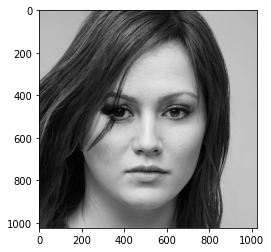

In [15]:
DATADIR = "/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela"
CATEGORIES = ["faces", "comics"]
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path):  
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
        plt.imshow(img_array, cmap='gray')  
        plt.show()  

        break  
    break  

In [16]:
#Check the image array
print("This is the image array:")
print(img_array)
print("  ")
print("This is the image shape:")
#Check the image shape
print(img_array.shape)

This is the image array:
[[182 178 175 ... 186 185 179]
 [182 179 175 ... 186 185 181]
 [182 179 176 ... 185 185 183]
 ...
 [ 69  53  49 ... 194 191 186]
 [ 85  54  42 ... 198 196 190]
 [ 93  55  38 ... 203 203 196]]
  
This is the image shape:
(1024, 1024)


#### *The next step is to convert all the images in grescale and resize them*
##### Plotting the different sizes we notice that a 128x128 is reasonably good.
##### We can visually compare the previous image with the new size.
##### Then, the complete dataset is created.
##### Shuffling is performed before separating images from labels
##### In the last cell the pixels values are normalized.

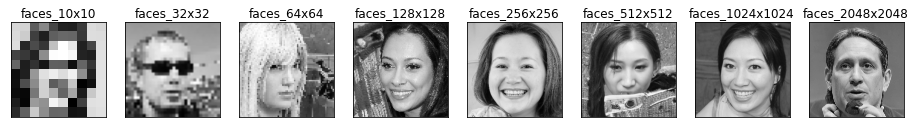

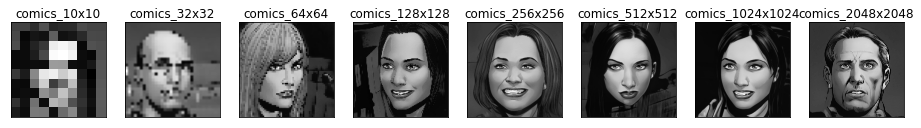

In [17]:
# plot the different sizes to understand visually how changes the definitions at human vision
DATADIR = "/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela"
sizes = [10, 32, 64, 128, 256, 512, 1024, 2048]
for class_label in CATEGORIES:
    plt.figure(figsize=(16,7))
    for image_number in range(0,8):
        plt.subplot(1,8,image_number+1)
        image_array = cv2.imread(os.path.join(os.path.join(DATADIR, class_label), os.listdir(os.path.join(DATADIR, class_label))[image_number]), 0)
        image_array = cv2.resize(image_array, (sizes[image_number], sizes[image_number]))
        plt.imshow(image_array, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(class_label + "_" + str(sizes[image_number]) + "x" + str(sizes[image_number]))

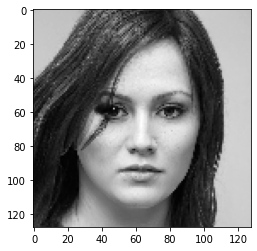

In [18]:
# Create the new array and check again the previous example image
new_array = cv2.resize(img_array, (128, 128))
plt.imshow(new_array, cmap='gray')
plt.show()

In [19]:
# Now I can create the complete dataset
# The first 10000 images are real faces (label 0) and the other 10000 are comics (label 1)
all_data = []

def create_all_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in os.listdir(path):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                new_array = cv2.resize(img_array, (128, 128))  
                all_data.append([new_array, class_num])  
            except Exception as e:
                pass
            

create_all_data()

print(len(all_data)) #20000 total images

20000


In [20]:
# SHUFFLING the data
random.shuffle(all_data)
# Check the shuffling
for sample in all_data[:10]:
    print(sample[1])

0
0
0
1
1
1
1
1
0
0


In [21]:
# Next, we separate images from labels
X = [] #Initialize empty list for images
y = [] #Initialize empty list for labels

# Fill the lists
for features,label in all_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, 128, 128, 1)) #Using a grescale I have to set 1 channel

X = np.array(X).reshape(-1, 128, 128, 1) 
y = np.array(y)

[[[[205]
   [206]
   [205]
   ...
   [202]
   [207]
   [206]]

  [[204]
   [205]
   [205]
   ...
   [203]
   [203]
   [204]]

  [[205]
   [204]
   [205]
   ...
   [205]
   [204]
   [202]]

  ...

  [[182]
   [173]
   [158]
   ...
   [ 62]
   [125]
   [187]]

  [[182]
   [181]
   [168]
   ...
   [ 61]
   [ 95]
   [121]]

  [[176]
   [175]
   [165]
   ...
   [ 30]
   [ 60]
   [ 62]]]]


In [22]:
#Normalization of pixels values
x = X/255.0 

#### *Training and Test splitting*
##### A random section of the dataset is left out to test the final clissifier.
##### On the other hand, the training set here obtain will be further partitioned due to computational performance reasons.


In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
# Check the lengths
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

16000
16000
4000
4000


#### *One-hot-encoding on labels*
##### Convert class vector into binary class matrices using Keras to_categorical function

In [24]:
# Equivalent to One-Hot-Encoding
y_train = keras.utils.np_utils.to_categorical(y_train, 2)
y_test = keras.utils.np_utils.to_categorical(y_test, 2)

In [ ]:
y_train.shape, y_test.shape

((16000, 2), (4000, 2))

#### *Check the best architecture: first hyperparameters tuning*
##### ATTENTION:
##### The following cells require more time to be executed. 
##### This is a first tuning aimed at finding a good baseline standard architecture.
#####Finally, the best architecture turns out to be with 3 convolutional layers and 32 layers' size. I keep this structure in the second hyperparameters tuning.

In [25]:
# I consider a subset of 4000 elements from the original training set due to execution time and computational resources limitations.
x_train_sub1, x_train_not1, y_train_sub1, y_train_not1 = train_test_split(x_train,y_train,test_size=0.75)
print(len(x_train_sub1)) #4000 elements
print(len(y_train_sub1)) #4000 elements

In [ ]:
dense_layers = [1]
layer_sizes = [32, 64, 128]
conv_layers = [2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=x_train_sub1.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(2))
            model.add(Activation('relu'))

            tensorboard = TensorBoard(log_dir="logs_opt_2r/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(x_train_sub1, y_train_sub1,
                      batch_size=32,
                      epochs=5,
                      validation_split=0.2,
                      callbacks=[tensorboard]
                      )

2-conv-32-nodes-1-dense-1661097861
Epoch 1/5
100/100 [==============================] - 58s 567ms/step - loss: 7.5970 - accuracy: 0.5047 - val_loss: 7.6246 - val_accuracy: 0.5213
Epoch 2/5
100/100 [==============================] - 54s 543ms/step - loss: 7.6246 - accuracy: 0.5047 - val_loss: 7.6246 - val_accuracy: 0.5213
Epoch 3/5
100/100 [==============================] - 56s 560ms/step - loss: 7.6246 - accuracy: 0.5047 - val_loss: 7.6246 - val_accuracy: 0.5213
Epoch 4/5
100/100 [==============================] - 55s 548ms/step - loss: 7.6246 - accuracy: 0.5047 - val_loss: 7.6246 - val_accuracy: 0.5213
Epoch 5/5
100/100 [==============================] - 57s 569ms/step - loss: 7.6246 - accuracy: 0.5047 - val_loss: 7.6246 - val_accuracy: 0.5213
3-conv-32-nodes-1-dense-1661098185
Epoch 1/5
100/100 [==============================] - 61s 599ms/step - loss: 0.4275 - accuracy: 0.8850 - val_loss: 0.1099 - val_accuracy: 0.9787
Epoch 2/5
100/100 [==============================] - 60s 599ms/ste

#### *Best model selection: second hyperparameters tuning*
##### From now on, we continue the optimization over the best architecture found. The only difference is a newly added dropout layer, in an attempt of limiting the risk of overfitting.
##### I divide once again the training set to obtain a new validation set and leave the original test set for final accuracy evaluation.
##### The hyperparameters tuned are the learning rate in the optimizer and the rate in the dropout layer.
##### Finally, the best Dropout rate is 0.5 and the best learning rate is 0.01

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [30]:
print("Train examples", x_train.shape)
print("Validation examples", x_val.shape)
print("Test examples", x_test.shape)

Train examples (14400, 128, 128, 1)
Validation examples (1600, 128, 128, 1)
Test examples (4000, 128, 128, 1)


In [31]:
np.unique(y_test, return_counts=True)

(array([0., 1.], dtype=float32), array([4000, 4000]))

In [32]:
y_train.shape, y_val.shape, y_test.shape

((14400, 2), (1600, 2), (4000, 2))

In [33]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

x_train shape: (14400, 128, 128, 1)
x_val shape: (1600, 128, 128, 1)
x_test shape: (4000, 128, 128, 1)


In [34]:
#hp.Choice('filters_1', values=[100, 200])

def build_model(hp):
    model = tf.keras.Sequential(
    [
        keras.Input(shape=x_train.shape[1:]),
        #convolutional layer
        keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
        #pooling layer
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #another convolutional layer
        keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
        #another pooling layer
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
     
        #another convolutional layer
        keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
        #another pooling layer
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        #flatten layer
        keras.layers.Flatten(),
        #dropout layer
        keras.layers.Dropout(hp.Choice('dropout_rate', values=[0.5, 0.7])),
        #last 2 neurons for the outcome
        keras.layers.Dense(2, activation="softmax")
    ])

    #compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3])),
                  metrics=['accuracy'])
    return model

In [35]:
tuner = Hyperband(build_model, 
                  objective='val_accuracy', 
                  max_epochs=10,
                  hyperband_iterations=1,
                  directory=DATADIR,
                  project_name='deep-learning-experiment_2')

In [36]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [37]:
# I tune the hyperparameters over the model. The number of trials is 4, coming from 2 values for 2 hyperparameters studied.
tuner.search(x=x_train, y=y_train, epochs=10, batch_size=200, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=[early_stop]) 

Trial 4 Complete [00h 08m 23s]
val_accuracy: 0.9950000047683716

Best val_accuracy So Far: 0.9975000023841858
Total elapsed time: 00h 33m 04s


In [38]:
#I get the best hyperparameters from the tuner 
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Hyperparameter for Dropout rate:", best_hps.get('dropout_rate'))
print("Hyperparameter for learning rate:", best_hps.get('lr'))

Hyperparameter for Dropout rate: 0.5
Hyperparameter for learning rate: 0.01


In [39]:
#Here I define the model over the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [40]:
#Here I fit the model over a random number of 10 epochs
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
450/450 [==============================] - 238s 527ms/step - loss: 0.1016 - accuracy: 0.9706 - val_loss: 0.0071 - val_accuracy: 0.9969
Epoch 2/10
450/450 [==============================] - 236s 524ms/step - loss: 0.0179 - accuracy: 0.9956 - val_loss: 0.0112 - val_accuracy: 0.9987
Epoch 3/10
450/450 [==============================] - 236s 525ms/step - loss: 0.0219 - accuracy: 0.9949 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 4/10
450/450 [==============================] - 237s 528ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0272 - val_accuracy: 0.9937
Epoch 5/10
450/450 [==============================] - 236s 524ms/step - loss: 0.0187 - accuracy: 0.9951 - val_loss: 0.0059 - val_accuracy: 0.9987
Epoch 6/10
450/450 [==============================] - 236s 525ms/step - loss: 0.0297 - accuracy: 0.9932 - val_loss: 0.0094 - val_accuracy: 0.9975
Epoch 7/10
450/450 [==============================] - 236s 525ms/step - loss: 0.0211 - accuracy: 0.9954 - val_loss: 0.0066 -

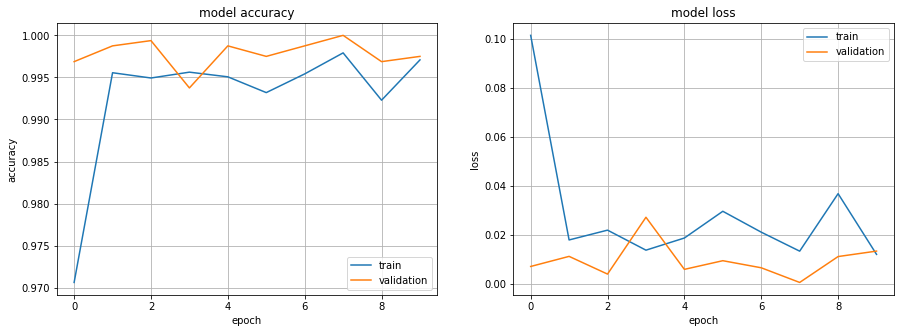

In [41]:
# Setting the plot for the accuracy
plt.figure(1, figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()

# Setting the plot for the loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [42]:
val_acc_per_epoch = history.history['val_accuracy']
best_number_of_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))
print('Best epoch: %d' % (best_number_of_epoch,))

Best epoch: 7


In [43]:
hypermodel = tuner.hypermodel.build(best_hps)

In [44]:
# re-train the model
hypermodel.fit(x_train, y_train, epochs=best_number_of_epoch, validation_data=(x_val, y_val))

Epoch 1/7
450/450 [==============================] - 265s 587ms/step - loss: 0.0667 - accuracy: 0.9759 - val_loss: 0.0117 - val_accuracy: 0.9975
Epoch 2/7
450/450 [==============================] - 238s 527ms/step - loss: 0.0227 - accuracy: 0.9942 - val_loss: 0.0030 - val_accuracy: 0.9981
Epoch 3/7
450/450 [==============================] - 237s 527ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 4/7
450/450 [==============================] - 237s 526ms/step - loss: 0.0333 - accuracy: 0.9931 - val_loss: 0.0037 - val_accuracy: 0.9987
Epoch 5/7
450/450 [==============================] - 236s 524ms/step - loss: 0.0355 - accuracy: 0.9926 - val_loss: 0.0115 - val_accuracy: 0.9962
Epoch 6/7
450/450 [==============================] - 236s 525ms/step - loss: 0.0128 - accuracy: 0.9955 - val_loss: 0.0015 - val_accuracy: 0.9994
Epoch 7/7
450/450 [==============================] - 236s 525ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0037 - val_ac

In [45]:
# Evaluatation of the final model on the the test set
score = hypermodel.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.009371528401970863
Test accuracy: 0.9977499842643738


In [46]:
pip install visualkeras #needed for network visualization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.2 MB/s 


In [47]:
import visualkeras #needed for network visualization

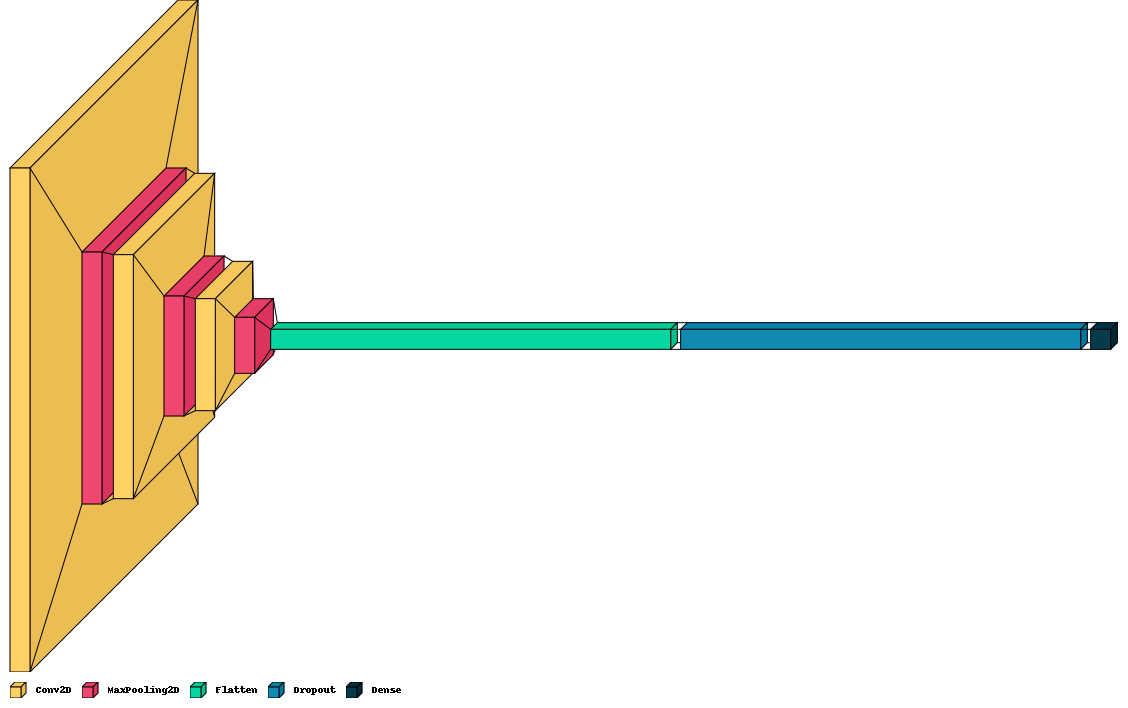

In [48]:
visualkeras.layered_view(hypermodel, legend=True, spacing=10)